<div class="usecase-title"><b>Banner Poles Booking</b></div>

<div class="usecase-authors"><b>Authored by: </b> Jamie Hoang</div>

<div class="usecase-duration"><b>Duration:</b> 60 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Pandas, Geospatial Analysis, Time-series Analysis</div>
</div>

<div class="usecase-section-header">Scenario</div>

* As a Melbourne business owner, I want to find a suitable location which  to book banners to promote for my events or festival.
* As a council planner, I want to measure the potential streets that have high level of foot traffics and forecast the foot traffic some next months

<div class="usecase-section-header">What this use case will teach you</div>

To support Melbourne businesses and event organizers in choosing the most effective locations for booking banner poles to promote their events, this use case will analyze seasonal foot traffic patterns and identify areas with the highest visitor attraction. This analysis will involve aggregating data to extract insights and conducting seasonal analysis at quarterly and monthly intervals. The overarching objective is to develop interactive maps that visually illustrate the correlation between high-volume foot traffic and the placement of banner poles.

At the end of this use case you will:
- Use the maps to identify areas with a high volume of pedestrian traffic.
- Learn to create interactive maps
- Examine the correlation between the placement of banner poles and pedestrian traffic levels
- Learn to use Prophet model in forecasting time series data.

<div class="usecase-section-header">Relavant datasets:</div>

- Bookable Banner Poles\
The dataset show the location of all bookable banner in City of Melbourne and have other information about banner poles such as booking group, model, type.
- Pedestrian Counting System (counts per hour)\
The dataset includes hourly pedestrian counts recorded from March 2023 to March 2024 by pedestrian sensor devices positioned throughout the city. Updated monthly, this data offers insights into fluctuations in pedestrian activity over the course of a day.

- Pedestrian Counting System - Sensor Locations\
The dataset includes information about the status, position, and directionality of each pedestrian sensor device installed across the city.

#### Import required libraries

In [1]:
import requests
import pandas as pd
import numpy 
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# pip install folium
import folium
from folium import Circle, Marker
from folium.plugins import MarkerCluster

# pip install prophet
from prophet import Prophet
from prophet.plot import plot_yearly, plot_weekly

from sklearn.metrics import r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

### 1. Load all needed data sets 

Load <b>Bookable Banner Poles</b> data set

In [2]:
# https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/
dataset_id = 'bookable-banner-poles'

base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
apikey = "/Users/jamie/Documents/Jamie_MOP/key.txt"
dataset_id = dataset_id
format = 'csv'

url = f'{base_url}{dataset_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}

# GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    banner = pd.read_csv(StringIO(url_content), delimiter=';')
    print(banner.sample(10, random_state=999)) # Test
else:
    print(f'Request failed with status code {response.status_code}')

     asset_number                                  asset_description  \
135       1110136  Super Banner Pole - Queen St:  Franklin St Cen...   
490       1110403  Standard Banner Pole - Nicholson St: Victoria ...   
503       1109947  Super Banner Pole - Batman Ave: Flinders Stree...   
55        1109969  Super Banner Pole - Therry St: Elizabeth St & ...   
260       1109960  Super Banner Pole - Batman Ave: Near Willam Ba...   
687       1109902                    Banner Pole - Super Banner Pole   
139       1110081                    Banner Pole - Super Banner Pole   
556       1110132  Super Banner Pole - Queen St:  Franklin St Cen...   
311       1110417  Standard Banner Pole - Errol St: Victoria St -...   
567       1110193  Standard Banner Pole - Collins St: Elizabeth S...   

     banner_pole_type  book_group             model_descr_lupvalue  \
135               2.0        74.0  Banner Pole - Super Banner Pole   
490               6.0        71.0    Banner Pole - Standard Banner 

In [3]:
print(f'The dataset has', len(banner) ,'records.')
banner.head()

The dataset has 859 records.


,asset_number,asset_description,banner_pole_type,book_group,model_descr_lupvalue,model_no_lupvalue,lat,lon,location
0,1110157,Banner Pole - Super Banner Pole,2.0,17.0,Banner Pole - Super Banner Pole,310101-001,-37.823292,144.988663,"-37.82329155263138, 144.98866256674287"
1,1109877,Banner Pole - Super Banner Pole,2.0,92.0,Banner Pole - Super Banner Pole,310101-001,-37.817254,144.967254,"-37.817254228279225, 144.9672540044011"
2,1110079,Banner Pole - Super Banner Pole,2.0,58.0,Banner Pole - Super Banner Pole,310101-001,-37.801522,144.957055,"-37.80152225386091, 144.9570553422455"
3,1110078,Banner Pole - Super Banner Pole,2.0,58.0,Banner Pole - Super Banner Pole,310101-001,-37.801494,144.957063,"-37.80149363625414, 144.95706283173402"
4,1110112,Banner Pole - Super Banner Pole,2.0,59.0,Banner Pole - Super Banner Pole,310101-001,-37.801071,144.957135,"-37.80107087696859, 144.9571345615933"


Load <b>Pedestrian Counting System (counts per hour)</b> data set

In [4]:
# https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/
dataset_id = 'pedestrian-counting-system-monthly-counts-per-hour'

base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
apikey = "/Users/jamie/Documents/Jamie_MOP/key.txt"
dataset_id = dataset_id
format = 'csv'

url = f'{base_url}{dataset_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}

# GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    pedestrian = pd.read_csv(StringIO(url_content), delimiter=';')
    print(pedestrian.sample(10, random_state=999)) # Test
else:
    print(f'Request failed with status code {response.status_code}')

       sensor_name                  timestamp  locationid  direction_1  \
299310  FedCycle_T  2023-05-13T12:00:00+00:00         122           26   
273077   Spen201_T  2023-12-13T09:00:00+00:00         134          290   
230538        AG_T  2023-04-24T01:00:00+00:00          29          295   
545967     Col12_T  2024-03-10T11:00:00+00:00          18           13   
41658     FedPed_T  2023-08-04T11:00:00+00:00           7           17   
311686     Col15_T  2023-07-28T11:00:00+00:00          17          101   
503749       UM2_T  2024-03-04T12:00:00+00:00          43           24   
362060      ACMI_T  2023-08-31T11:00:00+00:00          72           84   
90696       ElFi_T  2023-06-07T09:00:00+00:00          84          466   
340770    Fra118_T  2023-11-03T10:00:00+00:00          51           74   

        direction_2  total_of_directions                    location  
299310           23                   49  -37.81862929, 144.97169395  
273077          337                  627  -

In [5]:
print(f'The dataset has', len(pedestrian) ,'records.')
pedestrian.head(5)

The dataset has 549976 records.


,sensor_name,timestamp,locationid,direction_1,direction_2,total_of_directions,location
0,RMIT14_T,2023-05-03T09:00:00+00:00,61,294,379,673,"-37.80767455, 144.96309114"
1,RMIT14_T,2023-05-03T13:00:00+00:00,61,78,64,142,"-37.80767455, 144.96309114"
2,Lat224_T,2023-05-02T14:00:00+00:00,62,63,46,109,"-37.80996494, 144.96216521"
3,Lat224_T,2023-05-02T20:00:00+00:00,62,50,27,77,"-37.80996494, 144.96216521"
4,Lat224_T,2023-05-02T21:00:00+00:00,62,61,42,103,"-37.80996494, 144.96216521"


The 'total_of_directions' column represents the sum of two columns: 'direction_1' and 'direction_2'. We will utilize this column as the pedestrian count in the use case.

Load <b>Pedestrian Counting System - Sensor Locations</b> data set

In [6]:
# https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/
dataset_id = 'pedestrian-counting-system-sensor-locations'

base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
apikey = "/Users/jamie/Documents/Jamie_MOP/key.txt"
dataset_id = dataset_id
format = 'csv'

url = f'{base_url}{dataset_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}

# GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    pedestrian_code = pd.read_csv(StringIO(url_content), delimiter=';')
    print(pedestrian_code.sample(10, random_state=999)) # Test
else:
    print(f'Request failed with status code {response.status_code}')

     location_id                                 sensor_description  \
60            69                Flinders Ln -Degraves St (Crossing)   
139          159                              516 Elizeberth Street   
29           120                                  Harbour Esplanade   
55            48                                QVM-Queen St (East)   
0             24                      Spencer St-Collins St (North)   
24           102                            North Melbourne Library   
18            82                               512 Elizabeth Street   
100           26                      QV Market-Elizabeth St (West)   
64            81                        Boyd Commuinty - Front door   
128          133  I-Hub Southern Cross Station - Lonsdale Street...   

    sensor_name installation_date                         note location_type  \
60     FLDegC_T        2020-06-03                          NaN       Outdoor   
139    Eli516_T        2024-01-29                         

In [7]:
print(f'The dataset has', len(pedestrian_code) ,'records.')
pedestrian_code.head(5)

The dataset has 140 records.


,location_id,sensor_description,sensor_name,installation_date,note,location_type,status,direction_1,direction_2,latitude,longitude,location
0,24,Spencer St-Collins St (North),Col620_T,2013-09-02,NaN,Outdoor,A,East,West,-37.818880,144.954492,"-37.81887963, 144.95449198"
1,25,Melbourne Convention Exhibition Centre,MCEC_T,2013-08-28,NaN,Outdoor,A,East,West,-37.824018,144.956044,"-37.82401776, 144.95604426"
2,36,Queen St (West),Que85_T,2015-01-20,"Pushbox Upgrade, 03/08/2023",Outdoor,A,North,South,-37.816525,144.961211,"-37.81652527, 144.96121062"
3,37,Lygon St (East),Lyg260_T,2015-02-11,"Pushbox Upgrade, 30/06/2023",Outdoor,A,North,South,-37.803103,144.966715,"-37.80310271, 144.96671451"
4,41,Flinders La-Swanston St (West),Swa31,2017-06-29,NaN,Outdoor,A,North,South,-37.816686,144.966897,"-37.81668634, 144.96689733"


The 'sensor_name' column is the unique code of each sensor. We also need to double check if the column has any duplicate data.

In [8]:
print(f'Number of sensor devices', len(pedestrian_code.sensor_name.unique()))

Number of sensor devices 136


### 2. Data Visualization and Interactive Maps

##### Counting daily and monthly pedestrians 

In [9]:
# Split the timestamp column to Dates and Time columns
pedestrian['Dates'] = pd.to_datetime(pedestrian['timestamp']).dt.date
pedestrian['Time'] = pd.to_datetime(pedestrian['timestamp']).dt.time
pedestrian.head(5)

,sensor_name,timestamp,locationid,direction_1,direction_2,total_of_directions,location,Dates,Time
0,RMIT14_T,2023-05-03T09:00:00+00:00,61,294,379,673,"-37.80767455, 144.96309114",2023-05-03,09:00:00
1,RMIT14_T,2023-05-03T13:00:00+00:00,61,78,64,142,"-37.80767455, 144.96309114",2023-05-03,13:00:00
2,Lat224_T,2023-05-02T14:00:00+00:00,62,63,46,109,"-37.80996494, 144.96216521",2023-05-02,14:00:00
3,Lat224_T,2023-05-02T20:00:00+00:00,62,50,27,77,"-37.80996494, 144.96216521",2023-05-02,20:00:00
4,Lat224_T,2023-05-02T21:00:00+00:00,62,61,42,103,"-37.80996494, 144.96216521",2023-05-02,21:00:00


In [10]:
# Count the daily pedestrians by each sensor
daily_count = pedestrian.groupby(['Dates','sensor_name'])['total_of_directions'].sum().reset_index()
daily_count.head(5)

,Dates,sensor_name,total_of_directions
0,2023-03-31,280Will_T,814
1,2023-03-31,488Mac_T,445
2,2023-03-31,574Qub_T,276
3,2023-03-31,ACMI_T,1899
4,2023-03-31,AG_T,1272


In [11]:
# Combine data to extract the sensors' location
daily_count = daily_count.merge(pedestrian_code[['sensor_description', 'sensor_name', 'longitude','latitude']], 
                 how = 'left', 
                 on = 'sensor_name')
daily_count.head(5)

,Dates,sensor_name,total_of_directions,sensor_description,longitude,latitude
0,2023-03-31,280Will_T,814,Flagstaff station (East),144.956902,-37.812463
1,2023-03-31,488Mac_T,445,Macaulay Rd (North),144.929734,-37.794324
2,2023-03-31,574Qub_T,276,Queensberry St - Errol St (South),144.949081,-37.803100
3,2023-03-31,ACMI_T,1899,Flinders St- ACMI,144.968728,-37.817263
4,2023-03-31,AG_T,1272,St Kilda Rd-Alexandra Gardens,144.968635,-37.819658


In [12]:
# Check the missing values
daily_count.isnull().sum()

Dates                    0
sensor_name              0
total_of_directions      0
sensor_description     370
longitude              370
latitude               370
dtype: int64

All the missing values are on the last three columnns and there are the same numbers of missing values so they could come from the same sensors, we will extract these sensors' location of missing values  and replace it with the data we found in pedestrian data set.

In [13]:
# Find the sensors which do not have location in sensor Dataframe
daily_count[daily_count['longitude'].isnull()]['sensor_name'].unique()

array(['BouBri_T', 'Bou655_T', 'Col892T'], dtype=object)

In [14]:
# Extract the location of these sensors from pedestrian data
pedestrian[pedestrian['sensor_name'].isin(['BouBri_T', 'Bou655_T', 'Col892T'])].drop_duplicates('sensor_name')

,sensor_name,timestamp,locationid,direction_1,direction_2,total_of_directions,location,Dates,Time
368,Bou655_T,2023-05-06T07:00:00+00:00,73,89,200,289,"-37.81695684, 144.95415373",2023-05-06,07:00:00
792,BouBri_T,2023-05-04T14:00:00+00:00,57,9,12,21,"-37.8176735, 144.95025594",2023-05-04,14:00:00
6822,Col892T,2023-11-29T20:00:00+00:00,130,5,10,15,"-37.8204637, 144.94126826",2023-11-29,20:00:00


In [15]:
# Impute the missing location of specific sensors
daily_count.loc[daily_count['sensor_name'] == 'BouBri_T','longitude'] = daily_count.loc[daily_count['sensor_name'] == 'BouBri_T','longitude'].fillna(144.95025594)
daily_count.loc[daily_count.sensor_name == 'BouBri_T','latitude'] = daily_count.loc[daily_count.sensor_name == 'BouBri_T','latitude'].fillna(-37.8176735)

daily_count.loc[daily_count.sensor_name == 'Bou655_T','longitude'] = daily_count.loc[daily_count.sensor_name == 'Bou655_T','longitude'].fillna(144.95415373)
daily_count.loc[daily_count.sensor_name == 'Bou655_T','latitude'] = daily_count.loc[daily_count.sensor_name == 'Bou655_T','latitude'].fillna(-37.81695684)

daily_count.loc[daily_count.sensor_name == 'Col892T','longitude'] = daily_count.loc[daily_count.sensor_name == 'Col892T','longitude'].fillna(144.94126826)
daily_count.loc[daily_count.sensor_name == 'Col892T','latitude'] = daily_count.loc[daily_count.sensor_name == 'Col892T','latitude'].fillna(-37.8204637)

After handling all missing values, we create an interactive map for a particular date '2024-03-18'

In [16]:
m_1 = folium.Map(location=[-37.82401776, 144.95604426], tiles='cartodbpositron', zoom_start=14)

for idx, row in banner.iterrows():
    Marker([row['lat'], row['lon']],popup=row['asset_description']).add_to(m_1)

def color_producer(val):
    if val < 3000:
        return 'forestgreen'
    elif val < 8000:
        return 'darkorange'
    else:
        return 'darkred'

daily_count.Dates = pd.to_datetime(daily_count.Dates)

# Choose a date to map
date = daily_count[daily_count.Dates == '2024-03-18'].reset_index(drop=True)

for idx, row in date.iterrows():
    Circle(
        [row['latitude'], row['longitude']],
        color=color_producer(date.iloc[idx]['total_of_directions'])).add_to(m_1)

# Display the map
m_1

The map displays pedestrian foot traffic with varying intensity levels:

*   Red circles represent areas with a daily pedestrian count exceeding 8000.
*   Orange circles indicate areas with pedestrian counts ranging between 3000 and 8000.
*   Green circles represent areas with pedestrian counts below 3000.

In [17]:
daily_count.groupby(['Dates','sensor_name']).mean()['total_of_directions'].to_frame()

total_of_directions
Dates      sensor_name                     
2023-03-31 280Will_T                  814.0
           488Mac_T                   445.0
           574Qub_T                   276.0
           ACMI_T                    1899.0
           AG_T                      1272.0
...                                     ...
2024-03-18 UM3_T                      793.0
           VAC_T                    13078.0
           WatCit_T                  1108.0
           WebBN_T                   3676.0
           WestWP_T                   564.0

[26221 rows x 1 columns]

#### Monthly Foot Traffic

* Statistic the pedestrian count monthly based on each sensor location

In [18]:
# Convert date column to datetime objects
pedestrian['Dates'] = pd.to_datetime(pedestrian['Dates']) 

# Count the monthly pedestrians by each sensor
monthly_count = pedestrian.groupby([pedestrian['Dates'].dt.to_period('M'), 'sensor_name'])['total_of_directions'].sum().reset_index()
monthly_count.head()

,Dates,sensor_name,total_of_directions
0,2023-03,280Will_T,814
1,2023-03,488Mac_T,445
2,2023-03,574Qub_T,276
3,2023-03,ACMI_T,1899
4,2023-03,AG_T,1272


In [19]:
# Combine data to extract the sensors' location
monthly_count = monthly_count.merge(daily_count[['sensor_description', 'sensor_name', 'longitude','latitude']], 
                 how = 'left', 
                 on = 'sensor_name')
monthly_count.head()

,Dates,sensor_name,total_of_directions,sensor_description,longitude,latitude
0,2023-03,280Will_T,814,Flagstaff station (East),144.956902,-37.812463
1,2023-03,280Will_T,814,Flagstaff station (East),144.956902,-37.812463
2,2023-03,280Will_T,814,Flagstaff station (East),144.956902,-37.812463
3,2023-03,280Will_T,814,Flagstaff station (East),144.956902,-37.812463
4,2023-03,280Will_T,814,Flagstaff station (East),144.956902,-37.812463


In [20]:
# Drop the duplicate rows after merging
monthly_count = monthly_count.drop_duplicates(['Dates', 'sensor_name']).reset_index(drop=True)

In [21]:
m_2 = folium.Map(location=[-37.82401776, 144.95604426], tiles='cartodbpositron', zoom_start=14)

def color_producer(val):
    if val < 30000:
        return 'forestgreen'
    elif val < 150000:
        return 'darkorange'
    else:
        return 'darkred'

# Choose a month to map
month = monthly_count[monthly_count.Dates == '2024-03'].reset_index(drop=True)

for idx, row in month.iterrows():
    Circle(
        [row['latitude'], row['longitude']],
        radius=100,
        tooltip = f"{row['sensor_description']}, count {row['total_of_directions']}",
        color=color_producer(month.iloc[idx]['total_of_directions'])).add_to(m_2)

# Display the map
m_2

Similar to the daily foot traffic map, different colors show different intensity levels:

*   Red circles represent areas with a monthly pedestrian count exceeding 150000.
*   Orange circles indicate areas with pedestrian counts ranging between 30000 and 150000.
*   Green circles represent areas with pedestrian counts below 30000.

#### Seasonal Foot Traffic

The weather in Melbourne is divided into four seasons, so foot traffic may vary in each season due to factors such as tourist influx and weather conditions. Therefore, we will plot the average monthly foot traffic for each season to compare, making it easier to decide the best time to book the banner poles.


#### Summer Foot Traffic

In the next 4 following maps:
*   Red circles represent areas with a monthly pedestrian count exceeding 400000.
*   Orange circles indicate areas with pedestrian counts ranging between 150000 and 400000.
*   Green circles represent areas with pedestrian counts below 150000.

In [22]:
m_3 = folium.Map(location=[-37.82401776, 144.95604426], tiles='cartodbpositron', zoom_start=14)

def color_producer(val):
    if val < 150000:
        return 'forestgreen'
    elif val < 400000:
        return 'darkorange'
    else:
        return 'darkred'

summer_months = ['2023-12', '2024-01', '2024-02']
summer = monthly_count[monthly_count['Dates'].astype(str).isin(summer_months)].groupby(['sensor_name']).mean().reset_index()

for idx, row in summer.iterrows():
    Circle(
        [row['latitude'], row['longitude']],
        radius=100,
        color=color_producer(summer.iloc[idx]['total_of_directions'])).add_to(m_3)

# Display the map
m_3

#### Autumn Foot Traffic

In [23]:
m_4 = folium.Map(location=[-37.82401776, 144.95604426], tiles='cartodbpositron', zoom_start=14)

# Filter the DataFrame for the desired months
autumn_months = ['2023-03', '2023-04', '2023-05','2024-03']
autumn = monthly_count[monthly_count['Dates'].astype(str).isin(autumn_months)].groupby(['sensor_name']).mean().reset_index()

for idx, row in autumn.iterrows():
    Circle(
        [row['latitude'], row['longitude']],
        radius=100,
        color=color_producer(autumn.iloc[idx]['total_of_directions'])).add_to(m_4)

# Display the map
m_4

#### Winter Foot Traffic

In [24]:
m_5 = folium.Map(location=[-37.82401776, 144.95604426], tiles='cartodbpositron', zoom_start=14)

# Filter the DataFrame for the desired months
winter_months = ['2023-06', '2023-07', '2023-08']
winter = monthly_count[monthly_count['Dates'].astype(str).isin(winter_months)].groupby(['sensor_name']).mean().reset_index()

for idx, row in winter.iterrows():
    Circle(
        [row['latitude'], row['longitude']],
        radius=100,
        color=color_producer(winter.iloc[idx]['total_of_directions'])).add_to(m_5)

# Display the map
m_5

##### Spring Foot Traffic

In [25]:
m_6 = folium.Map(location=[-37.82401776, 144.95604426], tiles='cartodbpositron', zoom_start=14)

spring_months = ['2023-09', '2023-10', '2023-11']
spring = monthly_count[monthly_count['Dates'].astype(str).isin(spring_months)].groupby(['sensor_name']).mean().reset_index()

for idx, row in spring.iterrows():
    Circle(
        [row['latitude'], row['longitude']],
        radius=150,
        color=color_producer(spring.iloc[idx]['total_of_directions'])).add_to(m_6)

# Display the map
m_6

From the four maps showing foot traffic across the four seasons, we can observe that foot traffic is highest in summer, indicated by the most red circles, implying a significant rise in pedestrian count compared to other seasons. Some streets experiencing high traffic include Swanston St, Spencer St, and Flinders St. Additionally, foot traffic in autumn and spring witnesses lower numbers, with a more frequent occurrence of green circles.

### 3. Forecasting Foot Traffic

Due to the large number of sensor devices forecasting foot traffic from all these sensors would be costly and time-consuming. Therefore, our next step involves selecting the 15 sensors with the highest foot traffic to forecast activity for the upcoming year.

* We will select these sensors based on the monthly_count

In [26]:
# Filter 15 sensors which have monthly pedestrian counts more than 600000
high_traffic = monthly_count.loc[monthly_count['total_of_directions']>600000,:].sensor_name.unique()
len(high_traffic)

15

Since we only have data for one year, we will utilize daily foot traffic as input to train a time series model and forecast foot traffic for the next 300 days. After having a list of the top high-traffic sensors, we will use these sensor names to select all relevant data from the daily_count dataset.

In [27]:
# Choose all instances from top 15 sensor locations
top_15 = daily_count[daily_count['sensor_name'].isin(high_traffic)].reset_index(drop=True)
top_15.head()

,Dates,sensor_name,total_of_directions,sensor_description,longitude,latitude
0,2023-03-31,Bou283_T,2256,Bourke Street Mall (South),144.965167,-37.813807
1,2023-03-31,Bou292_T,2724,Bourke Street Mall (North),144.965153,-37.813494
2,2023-03-31,Col620_T,7203,Spencer St-Collins St (North),144.954492,-37.818880
3,2023-03-31,ElFi_T,5957,Elizabeth St - Flinders St (East) - New footpath,144.965034,-37.817980
4,2023-03-31,Eli250_T,4081,Melbourne Central-Elizabeth St (East),144.962201,-37.811603


In [28]:
# Dispplay top 15 locations has highest foot traffic

m_7 = folium.Map(location=[-37.82401776, 144.95604426], tiles='cartodbpositron', zoom_start=14)

for idx, row in top_15.drop_duplicates('sensor_name').iterrows():
    Marker([row['latitude'], row['longitude']],
           popup=row['sensor_description'],
           icon =folium.Icon(color='darkred')).add_to(m_7)

# Display the map
m_7

Click on the marker to see the sensor location

* Visualising the time series to have the idea of seasonality, trend

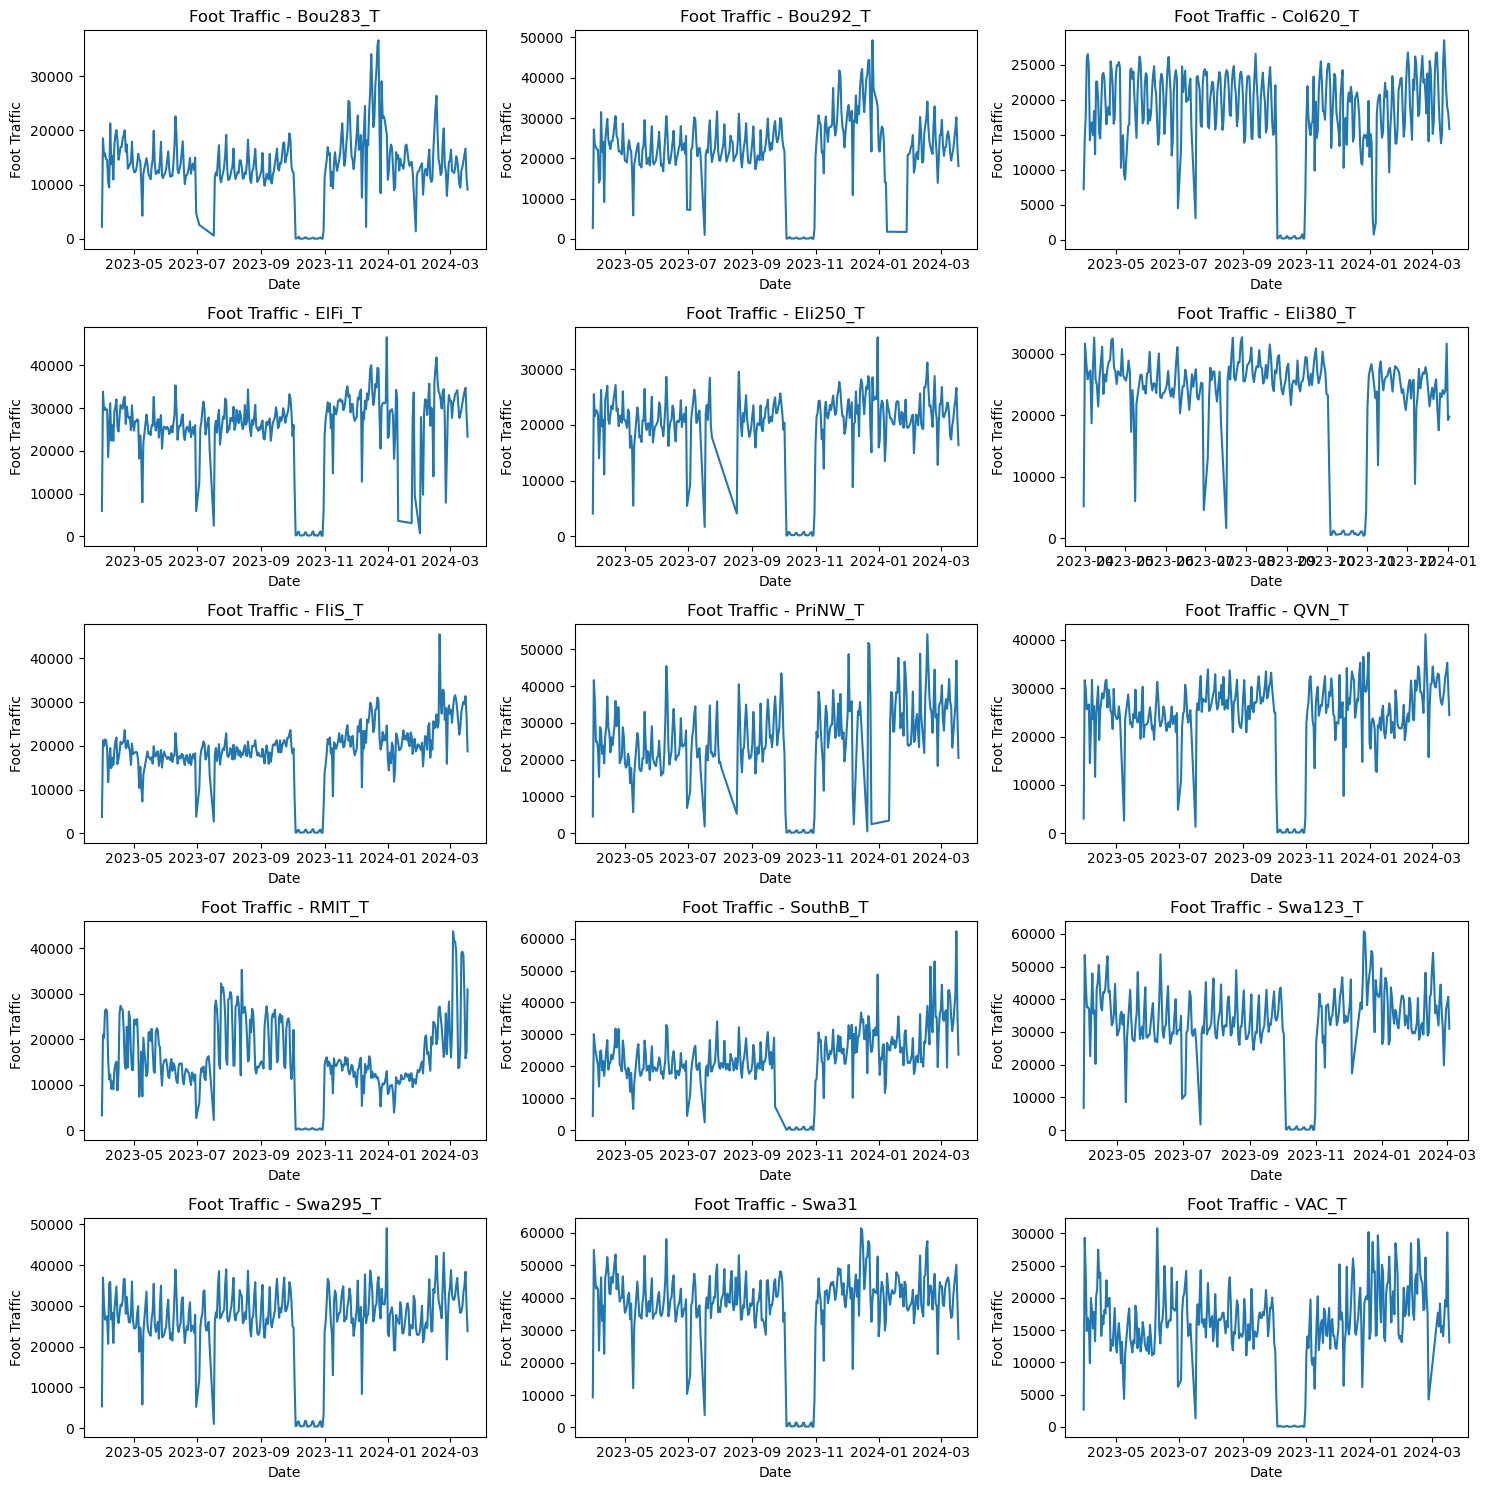

In [29]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot foot traffic for each sensor location
for i, (sensor, data) in enumerate(top_15.groupby('sensor_name')):
    ax = axes[i]
    sns.lineplot(x=data.Dates, y='total_of_directions', data=data, ax=ax)
    ax.set_title(f"Foot Traffic - {sensor}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Foot Traffic")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Most locations experience high foot traffic between December and February, while they reach low points between October and November. However, no discernible trend can be observed from the foot traffic data.

#### Apply Prophet model

Why we are using Prophet:
* Prophet is designed to automatically detect and model seasonal patterns in time series data. Even with just one year of data, Prophet can potentially identify and capture quarterly, monthly, or weekly seasonality patterns, if present in the data. This can improve the accuracy of the forecasts compared to models that do not account for seasonality.
* Prophet is designed to handle missing data and irregular time intervals effectively. With its robustness to missing values, it can still provide reliable forecasts even with a limited amount of historical data (325 days in this case)

* Select relevant columns to train the model

In [30]:
prophet_data = top_15.loc[:,['Dates','sensor_name','total_of_directions']]
prophet_data.head()

,Dates,sensor_name,total_of_directions
0,2023-03-31,Bou283_T,2256
1,2023-03-31,Bou292_T,2724
2,2023-03-31,Col620_T,7203
3,2023-03-31,ElFi_T,5957
4,2023-03-31,Eli250_T,4081


* Rename columns: Prophet has a strict requirement that the input data columns must be named precisely as 'ds' for the time column and 'y' for the metric or target variable column. Therefore, we need to rename the respective columns before providing the data to the Prophet model. 

In [31]:
prophet_data=prophet_data.rename(columns={'Dates': 'ds','total_of_directions':'y'})

prophet_data.head(3)

,ds,sensor_name,y
0,2023-03-31,Bou283_T,2256
1,2023-03-31,Bou292_T,2724
2,2023-03-31,Col620_T,7203


Then we train a separate Prophet model for each unique sensor in the prophet_data dataframe. It configures the model to capture weekly, yearly, and quarterly seasonality patterns. For each sensor, it generates a forecast for the next 300 days and stores the forecast dataframe with the sensor name in the p list. After the loop completes, all the individual forecasts are concatenated into a single dataframe p.

In [32]:
p = list()

for sensor in prophet_data['sensor_name'].unique():
    print('sensor:', sensor)
    model = Prophet(weekly_seasonality=True,yearly_seasonality=True )
    model.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5)

    # Fit the model to the data
    model.fit(prophet_data.loc[prophet_data['sensor_name']==sensor])
    
    # Predict foot traffic for the next 300 periods 
    future = model.make_future_dataframe(periods=300)
    forecast = model.predict(future)
    forecast['sensor_name'] = sensor
    
    p.append(forecast)
    
p = pd.concat(p, ignore_index=True)


sensor: Bou283_T


15:35:49 - cmdstanpy - INFO - Chain [1] start processing
15:35:49 - cmdstanpy - INFO - Chain [1] done processing
15:35:49 - cmdstanpy - INFO - Chain [1] start processing
15:35:49 - cmdstanpy - INFO - Chain [1] done processing


sensor: Bou292_T
sensor: Col620_T


15:35:49 - cmdstanpy - INFO - Chain [1] start processing
15:35:49 - cmdstanpy - INFO - Chain [1] done processing
15:35:49 - cmdstanpy - INFO - Chain [1] start processing
15:35:49 - cmdstanpy - INFO - Chain [1] done processing


sensor: ElFi_T


15:35:50 - cmdstanpy - INFO - Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing


sensor: Eli250_T


15:35:50 - cmdstanpy - INFO - Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing


sensor: Eli380_T
sensor: FliS_T


15:35:50 - cmdstanpy - INFO - Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing
15:35:50 - cmdstanpy - INFO - Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing


sensor: PriNW_T


15:35:50 - cmdstanpy - INFO - Chain [1] start processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing


sensor: QVN_T


15:35:51 - cmdstanpy - INFO - Chain [1] start processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing


sensor: RMIT_T


15:35:51 - cmdstanpy - INFO - Chain [1] start processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing


sensor: SouthB_T


15:35:51 - cmdstanpy - INFO - Chain [1] start processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing


sensor: Swa123_T


15:35:52 - cmdstanpy - INFO - Chain [1] start processing
15:35:52 - cmdstanpy - INFO - Chain [1] done processing


sensor: Swa295_T


15:35:52 - cmdstanpy - INFO - Chain [1] start processing
15:35:52 - cmdstanpy - INFO - Chain [1] done processing


sensor: Swa31


15:35:52 - cmdstanpy - INFO - Chain [1] start processing
15:35:52 - cmdstanpy - INFO - Chain [1] done processing


sensor: VAC_T


* Display the results 

In [33]:
p.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,quarterly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,sensor_name
9455,2025-01-08,32512.651568,28358.548837,37194.596610,32484.528672,32539.064147,337.471762,337.471762,337.471762,-784.806660,...,-401.353847,-401.353847,1523.632269,1523.632269,1523.632269,0.0,0.0,0.0,32850.123330,VAC_T
9456,2025-01-09,32548.268318,28161.606729,37068.401494,32519.987220,32574.816964,92.148553,92.148553,92.148553,-809.995528,...,-779.134605,-779.134605,1681.278687,1681.278687,1681.278687,0.0,0.0,0.0,32640.416871,VAC_T
9457,2025-01-10,32583.885069,29235.347511,37827.957405,32555.479489,32610.580703,997.471638,997.471638,997.471638,-771.179699,...,-41.931397,-41.931397,1810.582733,1810.582733,1810.582733,0.0,0.0,0.0,33581.356707,VAC_T
9458,2025-01-11,32619.501819,33363.719520,42365.795879,32590.924385,32646.324884,5214.224209,5214.224209,5214.224209,-678.192129,...,3983.845359,3983.845359,1908.570979,1908.570979,1908.570979,0.0,0.0,0.0,37833.726028,VAC_T
9459,2025-01-12,32655.118570,31555.753702,40659.550413,32626.321572,32682.085206,3478.443709,3478.443709,3478.443709,-545.240879,...,2050.691931,2050.691931,1972.992657,1972.992657,1972.992657,0.0,0.0,0.0,36133.562279,VAC_T


Prophet predicts the yhat column, which represents the point forecast, and calculates the yhat_lower and yhat_upper columns to provide the uncertainty intervals around the point forecast. These uncertainty intervals give an estimate of the range within which the actual future values are likely to fall.

* Plot the actual values and predicted values

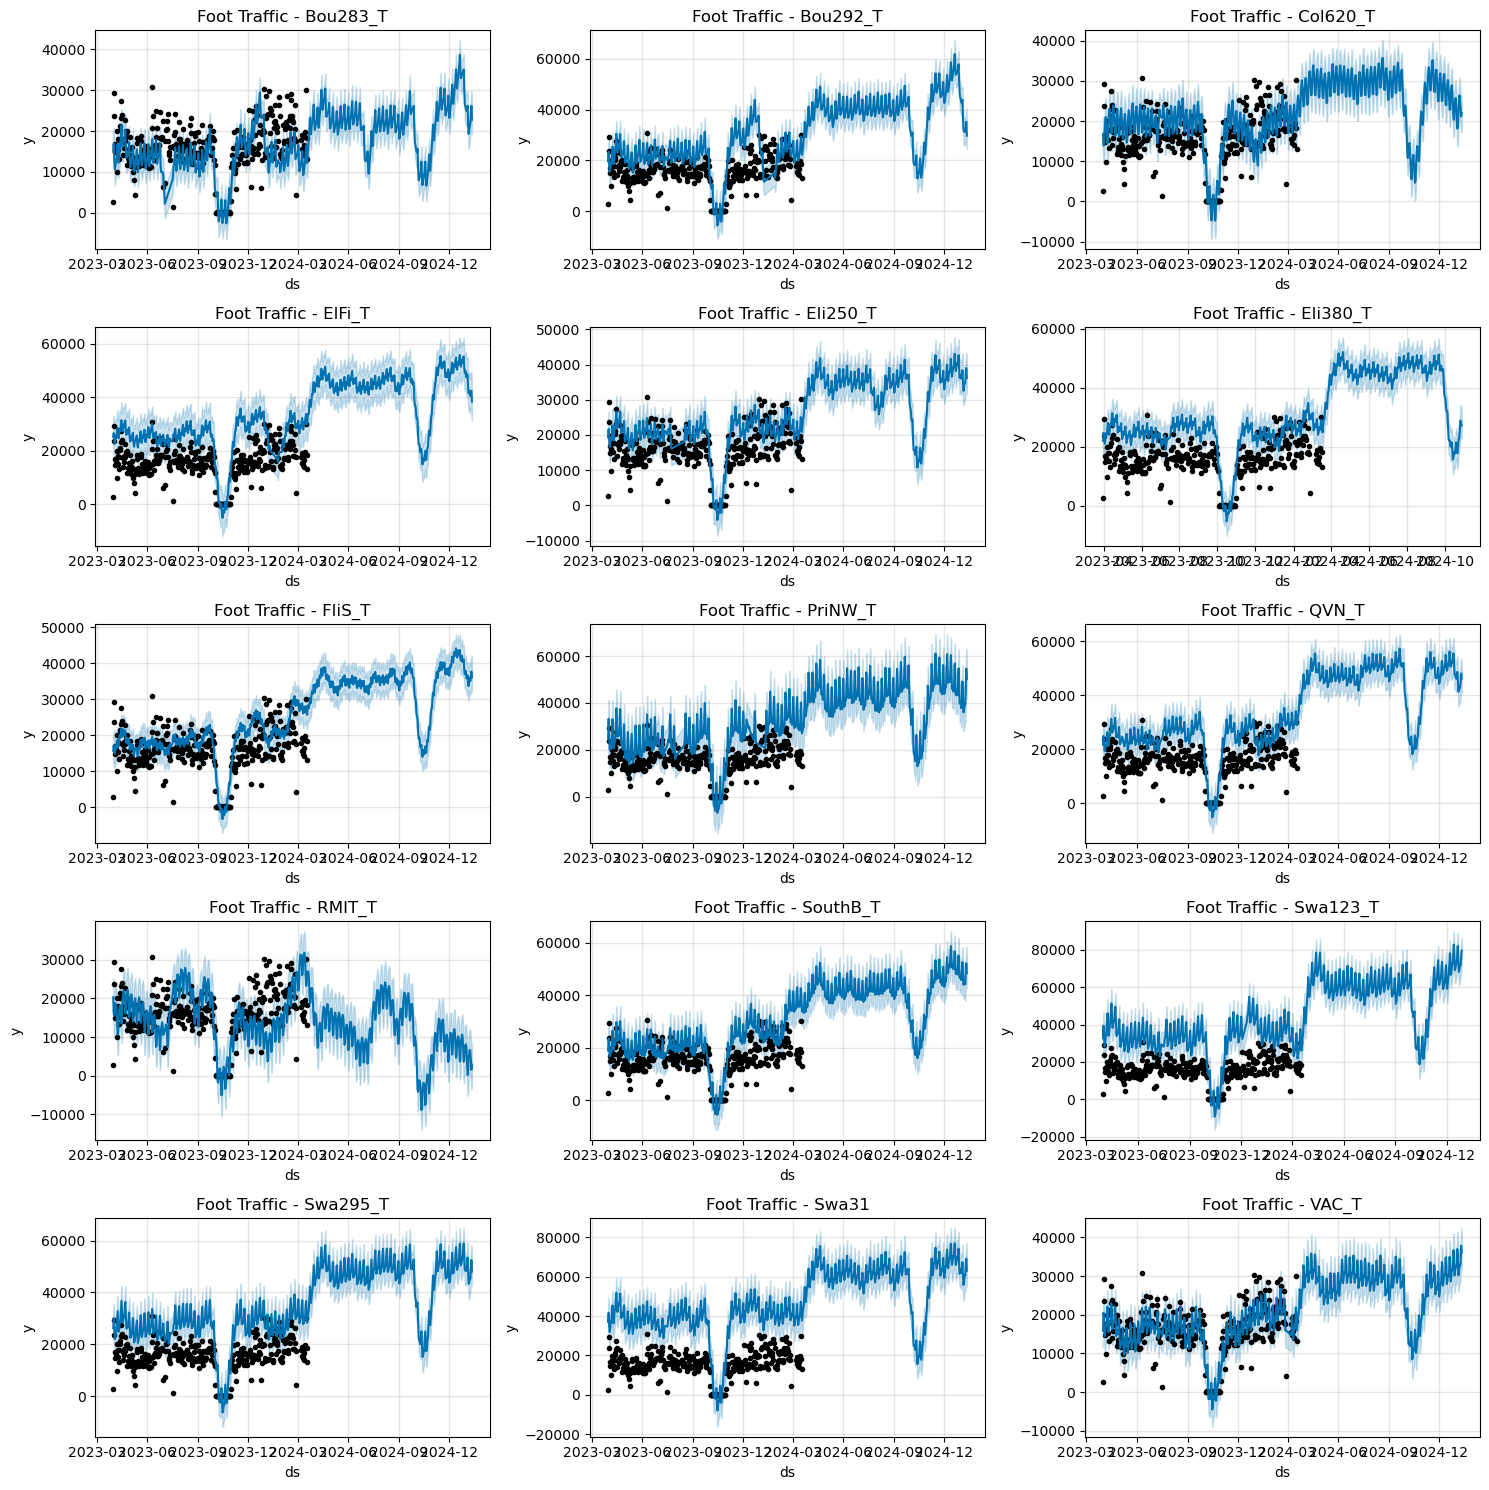

In [34]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

axes = axes.flatten()

for ax_ ,sensor in enumerate(p['sensor_name'].unique()):
    
    model.plot(p[p['sensor_name']==sensor], ax=axes[ax_])
    
    axes[ax_].set_title(f"Foot Traffic - {sensor}")
fig.tight_layout()
plt.show()

*The black dots represent the actual values amd blue one shows the forecast*

After examining 15 plots of actual and forecasted values from 15 sensor devices, we can observe that the model fits well for some locations, such as 'Bou283_T' and 'VAC_T'. For these sensors, the actual values align closely with the forecasted values, indicating a good fit.
However, for some other locations, the actual values deviate from the forecasted values, even though they may still fall within the uncertainty intervals. This suggests that the model parameters may not be optimal for accurately capturing the patterns in the data for certain sensors.
* Regarding the booking of banner poles, we would recommend that event organizers consider avoiding the placement of banner poles during periods of lowest foot traffic, such as October, November, and February.
* The analysis has shown that these months typically experience lower levels of pedestrian activity, which could result in fewer potential impressions or interactions with the banner advertisements. By strategically timing the banner pole placements during periods of higher foot traffic, event holders can maximize the visibility and potential impact of their promotional efforts.

* Visualize yearly and weekly seasonality components, respectively, of the forecasted time series data

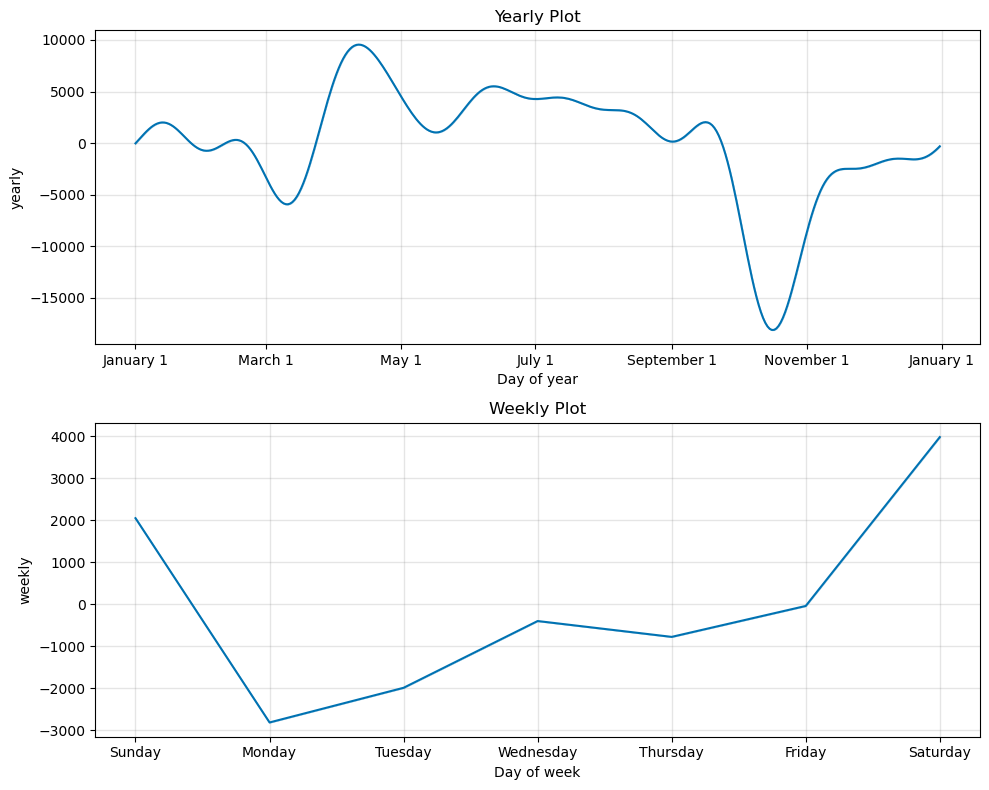

In [35]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 8))

a = plot_yearly(model,ax=axes[0])
b = plot_weekly(model,ax=axes[1])

# Customize plot titles
axes[0].set_title('Yearly Plot')
axes[1].set_title('Weekly Plot')

plt.tight_layout()
plt.show()

**The weekly subplot** shows a clear weekly seasonality pattern, with lower values on Sundays and higher values towards the weekend (Friday and Saturday), indicating a weekly cyclical pattern in the foot traffic. \
**The yearly subplot** displays the yearly seasonality component, revealing periodic peaks and troughs throughout the year. The highest peak occurs around mid-year, suggesting a seasonal increase in activity, while the lowest trough appears towards the end of the year, potentially indicating a seasonal decrease:
- To maximize the visibility and impact of banner pole advertisements, we would recommend scheduling the banner pole placements during the peak periods of the year. These peaks seem to occur around the middle of the year and towards the end of the year, suggesting that these time frames may be optimal for banner pole placements.
- On the other hand, it would be advisable to avoid placing banner poles during the trough periods when foot traffic is relatively low. These periods appear to be around the beginning of the year and potentially during the summer months, based on the seasonality pattern observed in the plot.


* Since the we do not have the yhat and y values on the same dat frame so we will join 2 tables (p and prophet_data) to extract y values

In [36]:
prophet_metric = p.merge(prophet_data, on=['ds', 'sensor_name'], how='left').reset_index()
prophet_metric.dropna(inplace=True)
prophet_metric.head()

,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,sensor_name,y
0,0,2023-03-31,8592.909624,11161.391037,18812.849018,8592.909624,8592.909624,6360.966441,6360.966441,6360.966441,...,1258.091802,4116.109980,4116.109980,4116.109980,0.0,0.0,0.0,14953.876065,Bou283_T,2256.0
1,1,2023-04-01,8618.515621,13156.482303,20784.531788,8618.515621,8618.515621,8289.763687,8289.763687,8289.763687,...,3401.953403,4866.329875,4866.329875,4866.329875,0.0,0.0,0.0,16908.279308,Bou283_T,18526.0
2,2,2023-04-02,8644.121618,9230.471597,16362.435495,8644.121618,8644.121618,4177.633931,4177.633931,4177.633931,...,-446.549807,5579.422511,5579.422511,5579.422511,0.0,0.0,0.0,12821.755550,Bou283_T,15324.0
3,3,2023-04-03,8669.727616,6648.630674,14604.608792,8669.727616,8669.727616,1947.985167,1947.985167,1947.985167,...,-2418.710676,6247.617213,6247.617213,6247.617213,0.0,0.0,0.0,10617.712782,Bou283_T,15760.0
4,4,2023-04-04,8695.333613,7808.250693,15202.341650,8695.333613,8695.333613,2706.780784,2706.780784,2706.780784,...,-1461.243786,6864.105328,6864.105328,6864.105328,0.0,0.0,0.0,11402.114397,Bou283_T,14668.0


* Measure the model's performance

In [37]:
# Create an empty DataFrame to store the metrics
metrics_table = pd.DataFrame(columns=['Sensor', 'MAE', 'R2_score'])

for sensor in prophet_metric['sensor_name'].unique():
    sensor_data = prophet_metric[prophet_metric['sensor_name'] == sensor]
    mae = mean_absolute_error(sensor_data['y'], sensor_data['yhat'])
    r2 = r2_score(sensor_data['y'], sensor_data['yhat'])
    metrics_table = metrics_table.append({'Sensor': sensor, 'MAE': mae, 'R2_score': r2}, ignore_index=True)

print(metrics_table)


      Sensor          MAE  R2_score
0   Bou283_T  1980.304061  0.759173
1   Bou292_T  2779.127999  0.787006
2   Col620_T  2320.506733  0.747170
3     ElFi_T  3417.000420  0.700392
4   Eli250_T  2410.122622  0.742556
5   Eli380_T  2440.226143  0.777697
6     FliS_T  2097.905495  0.796481
7    PriNW_T  4362.205169  0.698242
8      QVN_T  2851.833008  0.746232
9     RMIT_T  3109.255661  0.738164
10  SouthB_T  3171.663583  0.767011
11  Swa123_T  3926.319998  0.789603
12  Swa295_T  2953.166072  0.762979
13     Swa31  4303.157521  0.764338
14     VAC_T  2576.293920  0.717683


As we can observe, the R-squared scores range from 68% to 78% across 15 sensor locations. It can be interpreted to mean that 68% to 78% of the variance in this data is explained by the model. These values indicate that the model is doing a reasonably good job of capturing the relationship between the independent and targets \
For this model, the MAEs range around 2100 to more than 4000 , which really isn’t all that bad. What we can explain from the score is that for each data point, the average magnitude of errors are roughly between 2100 to 4000, which is reasonably accepted when we are looking at pedestrian counts in the 30K to 60K range.


### Recommendations for next trimester

**To improve maps**: 
- Enhancing interactive maps with additional features, such as allowing viewers to select a specific day or month directly on the plot, eliminates the need for manual code adjustments.


**To  improve the model**:
- In the next trimester, we could take into account any particular events, holidays, or local circumstances in Victoria and add them as the new features that might impact foot traffic patterns. By integrating these extra factors alongside the annual seasonality, it can enhance the precision of the banner pole placement strategy.
- Grouping the sensor to specific groups based on the distance make forecast based on these groups

#### References:


1. BANERJEE, P ‘Tutorial: Time Series Forecasting with Prophet’, kaggle.com, retrieved May 10, 2024, from <https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet#5.-Basic-Setup->.
2. Merwe, R van der 2018, ‘Implementing Facebook Prophet efficiently’, Medium, retrieved May 10, 2024, from <https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3>.
3. ‘Quick Start’ 2022, Prophet, retrieved May 3, 2024, from <https://facebook.github.io/prophet/docs/quick_start.html#python-api>.
4. Resende, D 2023, ‘Time-Series Forecasting With Facebook Prophet’, Zero To Mastery, retrieved May 10, 2024, from <https://zerotomastery.io/blog/time-series-forecasting-with-facebook-prophet/#:~:text=Cross%2Dvalidation%20is%20an%20important>.